In [2]:
import numpy as np 
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import optuna
from category_encoders import OneHotEncoder, MEstimateEncoder, CatBoostEncoder, OrdinalEncoder
from sklearn import set_config
import category_encoders
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, f1_score, accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.preprocessing import FunctionTransformer,StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.metrics import auc, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
import warnings
from great_tables import GT, style ,exibble, from_column, loc
from colorama import Style, Fore

sns.set_theme(style = 'white', palette = 'colorblind')
pal = sns.color_palette('colorblind')

pd.set_option('display.max_rows', 100)
set_config(transform_output = 'pandas')
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_rows', 150)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [6]:
train = pd.read_csv(r'data/train.csv', index_col='id')
test = pd.read_csv(r'data/test.csv', index_col='id')
#original = pd.read_csv('/data/predict-students-dropout-and-academic-success/data.csv')
sub  = pd.read_csv(r'data/sample_submission.csv')

In [7]:
TARGET = 'Target'
CAT_COLS =['Marital status', 'Application mode', 'Course',
           'Previous qualification', 'Nacionality', "Mother's qualification", 
           "Father's qualification", "Mother's occupation","Debtor","Educational special needs",
           "Father's occupation", "Gender","Daytime/evening attendance"]
NUMERIC_COLS = [f for f in train._get_numeric_data() if (f not in TARGET) and (f not in CAT_COLS)]
print(f'Numeric cols: {len(NUMERIC_COLS)}')
print(f'Cat cols: {len(CAT_COLS)}')

Numeric cols: 23
Cat cols: 13


In [8]:
for feature in CAT_COLS:
    for df in [train, test]:
        df[feature] = df[feature].astype('category')

In [9]:
def customStatistic(df: pd.DataFrame(), categoric = False):
    num_cols = list(df._get_numeric_data())
    cat_cols = list(df.drop(num_cols,axis=1))
    if categoric:
        desc = pd.DataFrame(index = list(df[cat_cols]))
        df = df[cat_cols]
    else:
        desc = pd.DataFrame(index = list(df[num_cols]))
        df = df[num_cols]
        desc['skew'] = df[num_cols].skew()
        
    desc['type'] = df.dtypes
    desc['count'] = df.count()
    desc['nunique'] = df.nunique()
    desc['%unique'] = desc['nunique'] /len(df) * 100 
    desc['null'] = df.isnull().sum()
    desc['%null'] = desc['null'] / len(df) * 100
    desc = pd.concat([desc,df.describe().T.drop('count',axis=1)],axis=1)    

    desc = desc.round(2)
    return desc.reset_index().rename(columns={'index':'Column'}).sort_values(by=['type'])

In [10]:
stat = customStatistic(train,False)
GT(stat)\
    .tab_header(title='Descriptive Statistic - Train', subtitle='Numeric Fields')\
    .data_color(columns=['min','max','mean'],palette=['lightblue','lightcoral'],alpha=0.5)\
    .fmt_percent(columns=['%unique','%null'])

GT(_tbl_data=                                            Column   skew     type  count  \
0                                Application order   2.04    int64  76518   
19  Curricular units 2nd sem (without evaluations)  10.39    int64  76518   
17             Curricular units 2nd sem (approved)  -0.15    int64  76518   
16          Curricular units 2nd sem (evaluations)  -0.18    int64  76518   
15             Curricular units 2nd sem (enrolled)  -0.57    int64  76518   
14             Curricular units 2nd sem (credited)   9.48    int64  76518   
13  Curricular units 1st sem (without evaluations)  11.56    int64  76518   
10          Curricular units 1st sem (evaluations)   0.09    int64  76518   
9              Curricular units 1st sem (enrolled)   0.29    int64  76518   
11             Curricular units 1st sem (approved)  -0.12    int64  76518   
7                                    International  12.16    int64  76518   
6                                Age at enrollment   2.37    int64  76518   
5                               Scholarship holder   1.17    int64  76518   
4                          Tuition fees up to date  -2.55    int64  76518   
3                                        Displaced  -0.28    int64  76518   
8              Curricular units 1st sem (credited)   8.22    int64  76518   
21                                  Inflation rate   0.23  float64  76518   
12                Curricular units 1st sem (grade)  -1.27  float64  76518   
2                                  Admission grade   0.40  float64  76518   
18                Curricular units 2nd sem (grade)  -1.07  float64  76518   
1                   Previous qualification (grade)   0.22  float64  76518   
20                               Unemployment rate   0.23  float64  76518   
22                                             GDP  -0.38  float64  76518   

    nunique  %unique  null  %null    mean    std    min     25%     50%  \
0         8     0.01     0    0.0    1.64   1.23   0.00    1.00    1.00   
19       11     0.01     0    0.0    0.06   0.46   0.00    0.00    0.00   
17       21     0.03     0    0.0    4.01   2.77   0.00    1.00    5.00   
16       31     0.04     0    0.0    7.23   3.50   0.00    6.00    7.00   
15       22     0.03     0    0.0    5.93   1.63   0.00    5.00    6.00   
14       20     0.03     0    0.0    0.14   0.93   0.00    0.00    0.00   
13       12     0.02     0    0.0    0.06   0.41   0.00    0.00    0.00   
10       36     0.05     0    0.0    7.35   3.51   0.00    6.00    7.00   
9        24     0.03     0    0.0    5.89   1.67   0.00    5.00    6.00   
11       23     0.03     0    0.0    4.18   2.69   0.00    2.00    5.00   
7         2     0.00     0    0.0    0.01   0.08   0.00    0.00    0.00   
6        46     0.06     0    0.0   22.28   6.89  17.00   18.00   19.00   
5         2     0.00     0    0.0    0.25   0.43   0.00    0.00    0.00   
4         2     0.00     0    0.0    0.89   0.31   0.00    1.00    1.00   
3         2     0.00     0    0.0    0.57   0.50   0.00    0.00    1.00   
8        21     0.03     0    0.0    0.19   1.18   0.00    0.00    0.00   
21       13     0.02     0    0.0    1.23   1.40  -0.80    0.30    1.40   
12     1206     1.58     0    0.0   10.00   5.26   0.00   10.67   12.17   
2       668     0.87     0    0.0  125.36  12.56  95.00  118.00  124.60   
18     1234     1.61     0    0.0    9.63   5.55   0.00   10.00   12.14   
1       110     0.14     0    0.0  132.38  11.00  95.00  125.00  133.10   
20       11     0.01     0    0.0   11.52   2.65   7.60    9.40   11.10   
22       11     0.01     0    0.0   -0.08   2.25  -4.06   -1.70    0.32   

       75%     max  
0     2.00    9.00  
19    0.00   12.00  
17    6.00   20.00  
16    9.00   33.00  
15    6.00   23.00  
14    0.00   19.00  
13    0.00   12.00  
10    9.00   45.00  
9     6.00   26.00  
11    6.00   26.00  
7     0.00    1.00  
6    23.00   70.00  
5     0.00    1.00  
4     1.00    1.00  
3     1.00    1.00  
8

In [11]:
stat = customStatistic(test,False)
GT(stat)\
    .tab_header(title='Descriptive Statistic - Test', subtitle='Numeric Fields')\
    .data_color(columns=['min','max','mean'],palette=['lightblue','lightcoral'],alpha=0.5)\
    .fmt_percent(columns=['%unique','%null'])

GT(_tbl_data=                                            Column   skew     type  count  \
0                                Application order   2.05    int64  51012   
19  Curricular units 2nd sem (without evaluations)  10.10    int64  51012   
17             Curricular units 2nd sem (approved)  -0.18    int64  51012   
16          Curricular units 2nd sem (evaluations)  -0.23    int64  51012   
15             Curricular units 2nd sem (enrolled)  -0.53    int64  51012   
14             Curricular units 2nd sem (credited)   9.46    int64  51012   
13  Curricular units 1st sem (without evaluations)  11.36    int64  51012   
10          Curricular units 1st sem (evaluations)   0.05    int64  51012   
9              Curricular units 1st sem (enrolled)   0.30    int64  51012   
11             Curricular units 1st sem (approved)  -0.14    int64  51012   
7                                    International  13.04    int64  51012   
6                                Age at enrollment   2.39    int64  51012   
5                               Scholarship holder   1.19    int64  51012   
4                          Tuition fees up to date  -2.58    int64  51012   
3                                        Displaced  -0.28    int64  51012   
8              Curricular units 1st sem (credited)   8.35    int64  51012   
21                                  Inflation rate   0.24  float64  51012   
12                Curricular units 1st sem (grade)  -1.31  float64  51012   
2                                  Admission grade   0.42  float64  51012   
18                Curricular units 2nd sem (grade)  -1.10  float64  51012   
1                   Previous qualification (grade)   0.24  float64  51012   
20                               Unemployment rate   0.23  float64  51012   
22                                             GDP  -0.37  float64  51012   

    nunique  %unique  null  %null    mean    std    min     25%     50%  \
0         8     0.02     0    0.0    1.65   1.24   0.00    1.00    1.00   
19       10     0.02     0    0.0    0.06   0.47   0.00    0.00    0.00   
17       21     0.04     0    0.0    4.04   2.75   0.00    1.00    5.00   
16       30     0.06     0    0.0    7.27   3.43   0.00    6.00    8.00   
15       23     0.05     0    0.0    5.94   1.60   0.00    5.00    6.00   
14       19     0.04     0    0.0    0.13   0.88   0.00    0.00    0.00   
13       11     0.02     0    0.0    0.06   0.40   0.00    0.00    0.00   
10       34     0.07     0    0.0    7.39   3.46   0.00    6.00    7.00   
9        23     0.05     0    0.0    5.90   1.64   0.00    5.00    6.00   
11       23     0.05     0    0.0    4.22   2.67   0.00    2.00    5.00   
7         2     0.00     0    0.0    0.01   0.08   0.00    0.00    0.00   
6        46     0.09     0    0.0   22.21   6.76  17.00   18.00   19.00   
5         2     0.00     0    0.0    0.24   0.43   0.00    0.00    0.00   
4         2     0.00     0    0.0    0.90   0.31   0.00    1.00    1.00   
3         2     0.00     0    0.0    0.57   0.50   0.00    0.00    1.00   
8        21     0.04     0    0.0    0.18   1.15   0.00    0.00    0.00   
21       12     0.02     0    0.0    1.23   1.40  -0.80    0.30    1.40   
12     1121     2.20     0    0.0   10.09   5.22   0.00   10.75   12.20   
2       653     1.28     0    0.0  125.42  12.60  95.00  118.00  124.60   
18     1155     2.26     0    0.0    9.71   5.50   0.00   10.00   12.17   
1       108     0.21     0    0.0  132.33  10.89  95.00  125.00  133.10   
20       12     0.02     0    0.0   11.52   2.65   7.60    9.40   11.10   
22       10     0.02     0    0.0   -0.09   2.25  -4.06   -1.70    0.32   

       75%     max  
0     2.00    9.00  
19    0.00   10.00  
17    6.00   20.00  
16    9.00   33.00  
15    6.00   23.00  
14    0.00   19.00  
13    0.00   12.00  
10    9.00   45.00  
9     6.00   23.00  
11    6.00   23.00  
7     0.00    1.00  
6    23.00   70.00  
5     0.00    1.00  
4     1.00    1.00  
3     1.00    1.00  
8

In [12]:
def min_max_unique(data_train, data_test):
    
    df = pd.DataFrame(index=data_train.columns)
    summary = {}
    for col in data_train.columns:
        if pd.api.types.is_numeric_dtype(data_train[col]):  # Verifica se a coluna é numérica
            min_train = min(data_train[col])
            min_test = min(data_test[col])
            max_train = max(data_train[col])
            max_test = max(data_test[col])
            unique_train = len(data_train[col].unique())
            unique_test = len(data_test[col].unique())
            top5_train = sorted(data_train[col])[:5]
            top5_test = sorted(data_test[col])[:5]
        else:  
            min_train = min_test = max_train = max_test = None
            unique_train = len(data_train[col].unique())
            unique_test = len(data_test[col].unique())
            top5_train = top5_test = None
        summary[col] = [min_train, min_test, max_train, max_test, 
                        unique_train, unique_test]

    df = pd.DataFrame.from_dict(summary, orient='index', columns=['min_train', 'min_test', 'max_train', 'max_test', 
                                                                  'unique_train', 'unique_test'])\
        .reset_index().rename(columns={'index': 'columns'})


    return df

In [13]:
s = min_max_unique(train.drop(TARGET,axis=1),test)
GT(s)\
    .tab_header(title='Min Max Uniques', subtitle='Train and Test datasets')\
    .data_color(columns=['columns'],palette=['lightgray','lightgray'])    

GT(_tbl_data=                                           columns  min_train  min_test  \
0                                   Marital status        NaN       NaN   
1                                 Application mode        NaN       NaN   
2                                Application order       0.00      0.00   
3                                           Course        NaN       NaN   
4                       Daytime/evening attendance        NaN       NaN   
5                           Previous qualification        NaN       NaN   
6                   Previous qualification (grade)      95.00     95.00   
7                                      Nacionality        NaN       NaN   
8                           Mother's qualification        NaN       NaN   
9                           Father's qualification        NaN       NaN   
10                             Mother's occupation        NaN       NaN   
11                             Father's occupation        NaN       NaN   
12                                 Admission grade      95.00     95.00   
13                                       Displaced       0.00      0.00   
14                       Educational special needs        NaN       NaN   
15                                          Debtor        NaN       NaN   
16                         Tuition fees up to date       0.00      0.00   
17                                          Gender        NaN       NaN   
18                              Scholarship holder       0.00      0.00   
19                               Age at enrollment      17.00     17.00   
20                                   International       0.00      0.00   
21             Curricular units 1st sem (credited)       0.00      0.00   
22             Curricular units 1st sem (enrolled)       0.00      0.00   
23          Curricular units 1st sem (evaluations)       0.00      0.00   
24             Curricular units 1st sem (approved)       0.00      0.00   
25                Curricular units 1st sem (grade)       0.00      0.00   
26  Curricular units 1st sem (without evaluations)       0.00      0.00   
27             Curricular units 2nd sem (credited)       0.00      0.00   
28             Curricular units 2nd sem (enrolled)       0.00      0.00   
29          Curricular units 2nd sem (evaluations)       0.00      0.00   
30             Curricular units 2nd sem (approved)       0.00      0.00   
31                Curricular units 2nd sem (grade)       0.00      0.00   
32  Curricular units 2nd sem (without evaluations)       0.00      0.00   
33                               Unemployment rate       7.60      7.60   
34                                  Inflation rate      -0.80     -0.80   
35                                             GDP      -4.06     -4.06   

    max_train    max_test  unique_train  unique_test  
0         NaN         NaN             6            6  
1         NaN         NaN            22           20  
2       9.000    9.000000             8            8  
3         NaN         NaN            19           21  
4         NaN         NaN             2            2  
5         NaN         NaN            21           20  
6     190.000  190.000000           110          108  
7         NaN         NaN            18           18  
8         NaN         NaN            35           32  
9         NaN         NaN            39           36  
10        NaN         NaN            40           38  
11        NaN         NaN            56           49  
12    190.000  190.000000           668          653  
13      1.000    1.000000             2            2  
14        NaN         NaN             2            2  
15        NaN         NaN             2            2  
16      1.000    1.000000             2            2  
17        NaN         NaN             2            2  
18      1.000    1.000000             2            2  
19     70.000   70.000000            46           46  
20      1.000    1.000000             2            2  
2

## Plot Correlation

In [14]:
# def plot_correlation(df,label=''):
#     corr = df._get_numeric_data().corr(method='spearman')
#     mask = np.zeros_like(corr)
#     mask[np.triu_indices_from(mask)]=True
#     fig, ax = plt.subplots(figsize=(27,20))
#     sns.heatmap(data=corr, 
#                 mask=mask , 
#                 annot=True,
#                 cmap='icefire',
#                 annot_kws={'size': 12, 'rotation': 45},
#                 ax=ax
#                 );
#     ax.set_title(f'Correlation {label}',fontsize=25, fontweight='bold');

# plot_correlation(train,'train')

/var/folders/qq/_pxy1w012md00pykw2bn68bw0000gn/T/ipykernel_3404/4062317193.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


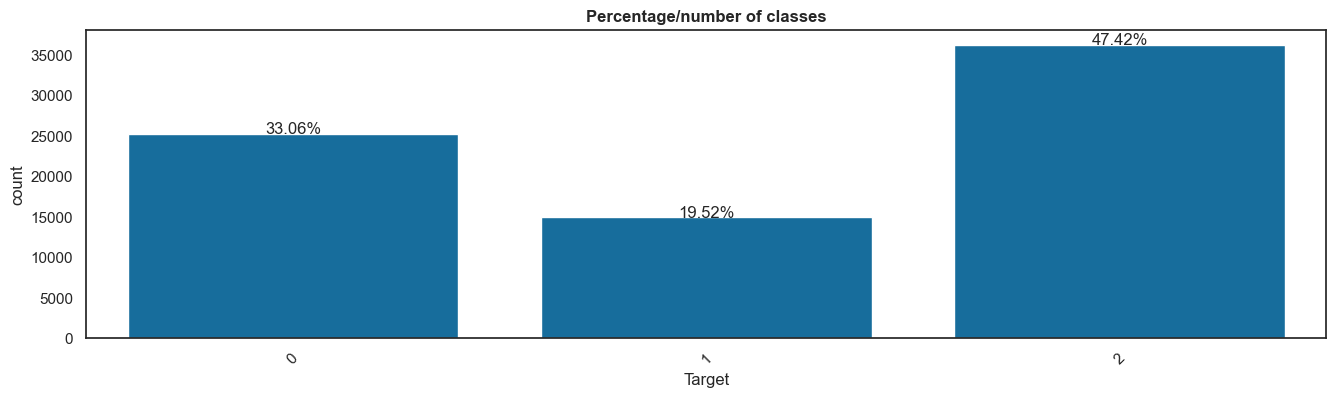

In [56]:
plt.figure(figsize = (16, 4))
ax = sns.countplot(x=train[TARGET])

total = len(train[TARGET])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.1,
            '{:.2%}'.format(height / total),
            ha="center")
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.title('Percentage/number of classes',fontweight='bold')
plt.show()

In [18]:
SUBMIT=False
SEED = 42
USE_ORIGINAL=False

In [19]:
scores, oof, test_predictions = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
lblTarget = LabelEncoder()
train[TARGET] = lblTarget.fit_transform(train[TARGET])
kf = StratifiedKFold(n_splits=5,random_state=SEED,shuffle=True)
oof_proba = np.zeros((len(train),3))

In [22]:
def printColor(pText: str):
    print(f'{Style.BRIGHT}{Fore.GREEN}{pText}{Style.RESET_ALL}')

def printInfo():
    print(f'{Style.BRIGHT}{Fore.YELLOW}SHAPE{Style.RESET_ALL}')
    print(f'{Style.BRIGHT}{Fore.GREEN} train: {train.shape}')
    print(f'{Style.BRIGHT}{Fore.GREEN} test:  {test.shape}')
    print(f'{Style.BRIGHT}{Fore.GREEN} original:  {original.shape}')    
    print(f'{Style.BRIGHT}{Fore.YELLOW}\nNULL VALUES{Style.RESET_ALL}')
    print(f'{Style.BRIGHT}{Fore.GREEN} train: {train.isnull().any().any()}')
    print(f'{Style.BRIGHT}{Fore.GREEN} test: {test.isnull().any().any()}')
    print(f'{Style.BRIGHT}{Fore.GREEN} original: {original.isnull().any().any()}')    
    print(f'{Style.BRIGHT}{Fore.YELLOW}\nDUPLICATES{Style.RESET_ALL}')
    print(f'{Style.BRIGHT}{Fore.GREEN} train: {train.duplicated().any().any()}')
    print(f'{Style.BRIGHT}{Fore.GREEN} test: {test.duplicated().any().any()}')
    print(f'{Style.BRIGHT}{Fore.GREEN} original: {original.duplicated().any().any()}')    

def score_model(estimator, label = '', verbose=False):
    
    X = train.copy()
    y = X.pop(TARGET)
    
    val_predictions = np.zeros((len(X)))
    test_predictions = np.zeros((len(test)))
    val_scores= []  
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
                    
        
        model = clone(estimator)        
        if isinstance(model, CatBoostClassifier):
            model.set_params(cat_features=CAT_COLS)
        
        X_train = X.iloc[train_idx].reset_index(drop = True)
        y_train = y.iloc[train_idx].reset_index(drop = True)

        X_val = X.iloc[val_idx].reset_index(drop = True)
        y_val = y.iloc[val_idx].reset_index(drop = True)
        
        if USE_ORIGINAL:
            X_train = pd.concat([X_train, original.drop([TARGET],axis=1)])
            y_train = pd.concat([y_train,original[TARGET]])
            
        model.fit(X_train, y_train)      
        val_preds = model.predict(X_val)
        val_predictions[val_idx] += val_preds.ravel()      
        oof_proba[val_idx] += model.predict_proba(X_val)
        
        val_score = accuracy_score(y_val, val_preds)
        val_scores.append(val_score)
        if verbose:
            print(f'Fold {fold+1}: {val_score:.5f}')
        
    if SUBMIT:
        X_train = train.copy()
        y_train = X_train.pop(TARGET) 
        model.fit(X_train,y_train)            
        test_predictions = model.predict_proba(test)
        
    printColor(f'Val Score: {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} | {label}')
         

    return val_scores, val_predictions, test_predictions

In [23]:
models = [               
    ('cb',CatBoostClassifier(random_state=SEED,cat_features=CAT_COLS,verbose=0,iterations=100)),
    ('rf', RandomForestClassifier(random_state = SEED)),
    ('et', ExtraTreesClassifier(random_state = SEED)),
    ('xgb', XGBClassifier(random_state = SEED)),
    ('lgb', LGBMClassifier(random_state = SEED, verbose=-1)),
    ('dart', LGBMClassifier(random_state = SEED,verbose=-1, boosting_type = 'dart')),    
    ('gb', GradientBoostingClassifier(random_state = SEED)),
    #('hgb', HistGradientBoostingClassifier(random_state = SEED)),
]

for (label, model) in models:
    print(label)
    if isinstance(model,CatBoostClassifier):
        scores[label], oof[label], test_predictions[label] = score_model(
                model,
                label)
    else:
        scores[label], oof[label], test_predictions[label] = score_model(
            make_pipeline(ce.MEstimateEncoder(cols=CAT_COLS), model),
            label
    )

cb
Val Score: 0.82892 ± 0.00128 | cb
rf
Val Score: 0.82622 ± 0.00248 | rf
et
Val Score: 0.82475 ± 0.00261 | et
xgb
Val Score: 0.83136 ± 0.00148 | xgb
lgb
Val Score: 0.83105 ± 0.00166 | lgb
dart
Val Score: 0.82843 ± 0.00150 | dart
gb
Val Score: 0.82783 ± 0.00142 | gb


In [24]:
y_pred = oof.mode(axis=1)[0].astype(int)
scores['ensemble'] = accuracy_score(train[TARGET],y_pred)

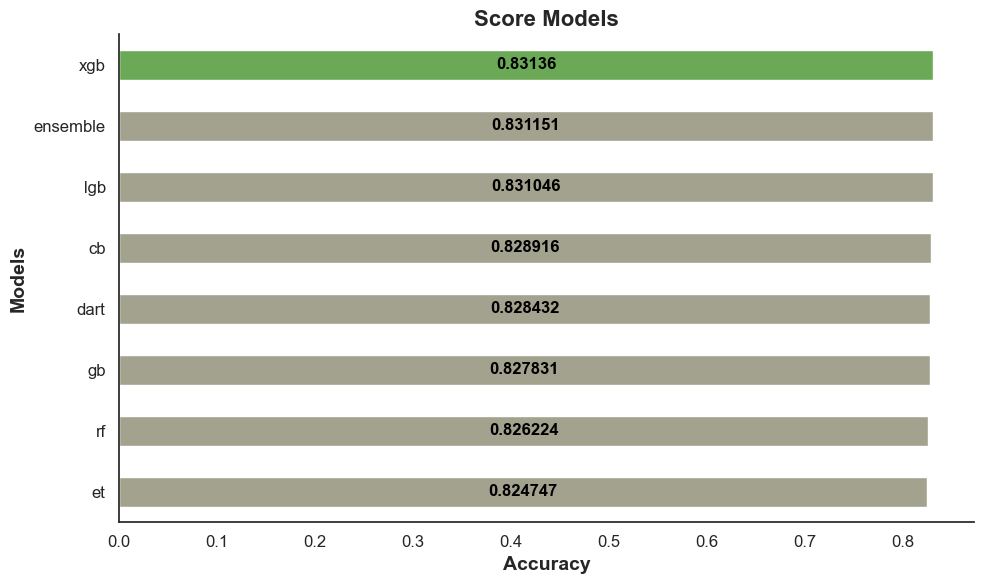

In [25]:
ax = scores.mean().sort_values(ascending=True).plot(kind='barh', figsize=(10, 6), color='#a2a28f')

for container in ax.containers:
    ax.bar_label(container, label_type='center', color='black', fontsize=12, fontweight='bold')
ax.patches[-1].set_facecolor('#6ca957')

ax.set_title('Score Models', fontsize=16, fontweight='bold')

ax.set_xlabel('Accuracy', fontsize=14, fontweight='bold')
ax.set_ylabel('Models', fontsize=14, fontweight='bold')

ax.tick_params(axis='both', which='major', labelsize=12)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

## Prediction

In [36]:
model = XGBClassifier(random_state = SEED)
estimator = make_pipeline(ce.MEstimateEncoder(cols=CAT_COLS), model)

In [40]:
X = train.copy()
y = X.pop(TARGET)

val_predictions = np.zeros((len(X)))
test_predictions = np.zeros((len(test)))
val_scores= []  

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
                
    model = clone(estimator)        
    if isinstance(model, CatBoostClassifier):
        model.set_params(cat_features=CAT_COLS)
    
    X_train = X.iloc[train_idx].reset_index(drop = True)
    y_train = y.iloc[train_idx].reset_index(drop = True)

    X_val = X.iloc[val_idx].reset_index(drop = True)
    y_val = y.iloc[val_idx].reset_index(drop = True)
    
    if USE_ORIGINAL:
        X_train = pd.concat([X_train, original.drop([TARGET],axis=1)])
        y_train = pd.concat([y_train,original[TARGET]])
        
    model.fit(X_train, y_train)      
    val_preds = model.predict(X_val)
    val_predictions[val_idx] += val_preds.ravel()      
    oof_proba[val_idx] += model.predict_proba(X_val)
    
    val_score = accuracy_score(y_val, val_preds)
    val_scores.append(val_score)

In [57]:
test_predictions = model.predict_proba(test)
test_predictions

array([[0.9946162 , 0.00150435, 0.0038794 ],
       [0.00362781, 0.00568954, 0.9906826 ],
       [0.02668727, 0.17006002, 0.8032527 ],
       ...,
       [0.9879362 , 0.00931535, 0.00274836],
       [0.86986107, 0.11461998, 0.0155189 ],
       [0.99272823, 0.00313774, 0.00413408]], dtype=float32)

In [63]:
#predictions = np.argmax(test_predictions, axis = 1)
lblTarget.inverse_transform(model.predict(test))

array(['Dropout', 'Graduate', 'Graduate', ..., 'Dropout', 'Dropout',
       'Dropout'], dtype=object)

In [53]:
sub['Target'] = lblTarget.inverse_transform(predictions)

In [55]:
sub.to_csv("Submission_June5.csv", index = False)